In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy
import sys
import time
from scipy import stats
from sklearn import preprocessing as preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import linear_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
def read_df (date, dataset_name):
    df = pd.read_csv(data_path + 'selected_patterns_' + dataset_name + '_' + date + '.csv', 
                                    delimiter=',',
                                    header=0, 
                                    index_col=0, 
                                    parse_dates=True)
    return df

In [5]:
def hampel(vals_orig, W=7, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    W: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    #Make copy so original not edited
    vals=vals_orig.copy()    
    #Hampel Filter
    L= 1.4826
    rolling_median=vals.rolling(W).median()
    difference=np.abs(rolling_median-vals)
    median_abs_deviation=difference.rolling(W).median()
    threshold= t0 * L * median_abs_deviation
    outlier_idx=difference>threshold
    vals[outlier_idx]=rolling_median #np.nan
    return(vals)

In [6]:
# Levenshtein Distance (edit distance) algorithm source code
# The code is adpoted from: https://www.geeksforgeeks.org/dynamic-programming-set-5-edit-distance/
# Written by Bhavya Jain.
def editDistDP(str1, str2):
    
    # Added by the "Shahrooz Abghari" for normalization purposes
    ############################################################
    m = len(str1)
    n = len(str2)
    if m < n:
        m, n = n, m
        str1, str2 = str2, str1
    ############################################################
    # Create a table to store results of subproblems
    dp = [[0 for x in range(n+1)] for x in range(m+1)]
    
    # Fill d[][] in bottom up manner
    for i in range(m+1):
        for j in range(n+1):
 
            # If first string is empty, only option is to
            # isnert all characters of second string
            if i == 0:
                dp[i][j] = j    # Min. operations = j
                
            # If second string is empty, only option is to
            # remove all characters of second string
            elif j == 0:
                dp[i][j] = i    # Min. operations = i
                
            # If last characters are same, ignore last char
            # and recur for remaining string
            elif str1[i-1] == str2[j-1]:
                dp[i][j] = dp[i-1][j-1]
                
            # If last character are different, consider all
            # possibilities and find minimum
            else:
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert
                                   dp[i-1][j],        # Remove
                                   dp[i-1][j-1])    # Replace
               
    return float(dp[m][n])/m # normalize the result by dividing it with the length of the longest pattern

In [7]:
def editDist_matrix(X, Y):
    test = []
    test = [[editDistDP(X[i], Y[j]) for j in range(len(Y))] for i in range(len(X))]
    a = pd.DataFrame(test)
    return a

In [8]:
def mfsp_finder(selected_patterns):
    mfsp = pd.DataFrame()
    mPattern_id = []
    mfsp_freq = []
    mPattern = []

    i = 0
    for name, group in selected_patterns.groupby('pattern'):
        if sum(group['frequency']) > 0:
            for date, group_1 in group.groupby(pd.Grouper(freq=Frequency)):
                if (len(group.index) - len(group_1.index)) >= 0:
                    mPattern_id.append([name, sum(group['frequency'])])
                    mfsp_freq.append(sum(group['frequency']))
                    mPattern.append(name.split(','))
                    mfsp = [mfsp, group]
                    mfsp = pd.concat(mfsp)
                    i += 1
                break
    return (mPattern_id, mPattern, mfsp, mfsp_freq)

In [9]:
def exemplar_to_pattern_distance(weekly_patterns, 
                                 clusters_exemplar, 
                                 clusters_label, 
                                 patterns_freq, 
                                 patterns_outdoor_temp):
    temp_1 = []

    cluster_area = []
    cluster_outdoor_temp = []
    
    for c in range(len(clusters_exemplar)):
        for i in clusters_exemplar[c]:

            temp_1.append(weekly_patterns[c][i])
        
        for j in range (len(set(clusters_label[c]))):
            freq_ = 0
            avg_outdoor_temp = 0
            count = 0
            
            for k, v, outdoor in zip(clusters_label[c], patterns_freq[c], patterns_outdoor_temp[c]):
                if k == j:
                    freq_ += v
                    count += 1
                    avg_outdoor_temp +=outdoor
            cluster_area.append(freq_)
            cluster_outdoor_temp.append(avg_outdoor_temp/count)
    return(editDist_matrix(temp_1, temp_1), cluster_area, temp_1, cluster_outdoor_temp) 

In [10]:
def weighted_clusters_distance(weekly_patterns, clusters_exemplar, clusters_label, patterns_freq):
    temp_1 = []
    temp_2 = []
    temp_3 = pd.DataFrame()
    
    for c in range(len(clusters_exemplar)):
        result = []
        cluster_area = []
        for i in clusters_exemplar[c]:
            result.append(weekly_patterns[c][i])
               
        for j in range (len(set(clusters_label[c]))):
            freq_ = 0
            for k, v in zip(clusters_label[c], patterns_freq[c]):
                if k == j:

                    freq_ += v
            cluster_area.append(freq_)
        temp_2.append(cluster_area)
        temp_1.append(result)

    temp_3 = editDist_matrix(temp_1[0], temp_1[1])
    
    sum_1 = 0
    for i in range(temp_3.shape[0]):
        sum_1 += temp_2[0][i] / sum(temp_2[0]) * temp_3.loc[i].min()

    sum_2 = 0
    for i in range(temp_3.shape[1]):
        sum_2 += temp_2[1][i] / sum(temp_2[1]) * temp_3[i].min()

    return(round(((sum_1  + sum_2 )/2),2), temp_3, temp_2, temp_1)  

In [11]:
def clusters_distance(weekly_patterns, clusters_exemplar, clusters_label, patterns_freq):
    temp_1 = []
    temp_2 = []
    temp_3 = pd.DataFrame()
    
    for c in range(len(clusters_exemplar)):
        result = []
        cluster_area = []
        for i in clusters_exemplar[c]:
            result.append(weekly_patterns[c][i])
               
        for j in range (len(set(clusters_label[c]))):
            freq_ = 0
            for k, v in zip(clusters_label[c], patterns_freq[c]):
                if k == j:

                    freq_ += v
            cluster_area.append(freq_)
        temp_2.append(cluster_area)
        temp_1.append(result)

    temp_3 = editDist_matrix(temp_1[0], temp_1[1])
    
    sum_1 = 0
    for i in range(temp_3.shape[0]):
        sum_1 += temp_3.loc[i].min()

    sum_2 = 0
    for i in range(temp_3.shape[1]):
        sum_2 += temp_3[i].min()
        
    return(round(((sum_1 / temp_3.shape[0] + sum_2 / temp_3.shape[1])/2),2), temp_3, temp_2, temp_1)

In [12]:
def zscore_(dataset, freq_):
    result = pd.DataFrame()
    for date, group in dataset.groupby(pd.Grouper(freq=freq_)):
        temp_ = []
        temp_.append(stats.zscore(group))
        result = [result, pd.DataFrame(temp_[0])]
        result = pd.concat(result, ignore_index=True)
    return(result.values.tolist())

In [13]:
data_dir = '/home/sab/jupyter-notebooks/smart_meters/noda_data/'
substations = ['F-4']

buildings_list = []
dataset = pd.DataFrame()

s_date = '2017-01-01' 
e_date = '2018-12-31'

len_data = len(pd.date_range(s_date,e_date, freq='H'))

for substation in substations:
    idx = []
    if substation == 'F-4':
    
        data_path = data_dir + substation + '/'

        dataset = keab_00T[substation].loc[s_date:e_date].fillna(method='ffill').resample('H').mean()
        dataset = dataset.drop(['meter_heatenergy','meter_volume'], axis=1)
        dataset = dataset.drop_duplicates()

        dataset.columns = ['outdoor_temp','sec_supply_temp', 'sec_return_temp','meter_effect',
                       'meter_prim_return_temp','meter_prim_supply_temp', 'meter_volume_flow']
        dataset['sec_delta_t'] = abs(dataset['sec_supply_temp'] - dataset['sec_return_temp'])
        dataset['prim_delta_t'] = abs(dataset['meter_prim_supply_temp'] - dataset['meter_prim_return_temp'])
        dataset['station_efficiency_temp'] = dataset['prim_delta_t'] / \
                                                     (dataset['meter_prim_supply_temp'] - dataset['sec_return_temp'])

        dataset = dataset[['sec_delta_t','prim_delta_t','meter_effect',
                          'meter_prim_return_temp','meter_prim_supply_temp',
                          'meter_volume_flow','outdoor_temp','sec_return_temp',
                         'sec_supply_temp', 'station_efficiency_temp']]

        print('Substation name: ', substation)
        print('Database length: ',len(dataset))
        print('Number of missing rows:', len_data - len(dataset))

        if len(dataset) < len_data:
            for date,group in dataset.groupby(pd.Grouper(freq='H')):
                if len(group) == 0:
                    idx.append(date)
            dataset = dataset.append(pd.DataFrame(index=idx), sort=False)
            dataset = dataset.sort_index()

        print('Number of missing values:')
        print(dataset.isna().sum())

        #fill the missing value with the average of the neighbourDictionary values
        dataset = (dataset.fillna(method='ffill') + dataset.fillna(method='bfill')) / 2
        dataset = dataset.fillna(method='bfill')
        
        hampel_dataset = hampel(dataset)
        hampel_dataset = pd.DataFrame(data = hampel_dataset, 
                              columns = ['sec_delta_t','prim_delta_t','meter_effect',
                                         'meter_prim_return_temp','meter_prim_supply_temp',
                                         'meter_volume_flow','outdoor_temp','sec_return_temp',
                                         'sec_supply_temp', 'station_efficiency_temp'],
                             index = dataset.index)

        hampel_dataset['year'] = hampel_dataset.index.year
        hampel_dataset['month'] = hampel_dataset.index.month
        hampel_dataset['weekday_name'] = hampel_dataset.index.weekday_name
        
        print('\nNumber of missing values after imputation:')
        print(hampel_dataset.isna().sum())
        print(len(hampel_dataset))
        print()
        
        hampel_dataset.name = 'hampel_dataset'

Substation name:  F-4
Database length:  17448
Number of missing rows: 49
Number of missing values:
sec_delta_t                73
prim_delta_t               73
meter_effect               73
meter_prim_return_temp     73
meter_prim_supply_temp     73
meter_volume_flow          73
outdoor_temp               73
sec_return_temp            73
sec_supply_temp            73
station_efficiency_temp    73
dtype: int64

Number of missing values after imputation:
sec_delta_t                0
prim_delta_t               0
meter_effect               0
meter_prim_return_temp     0
meter_prim_supply_temp     0
meter_volume_flow          0
outdoor_temp               0
sec_return_temp            0
sec_supply_temp            0
station_efficiency_temp    0
year                       0
month                      0
weekday_name               0
dtype: int64
17520



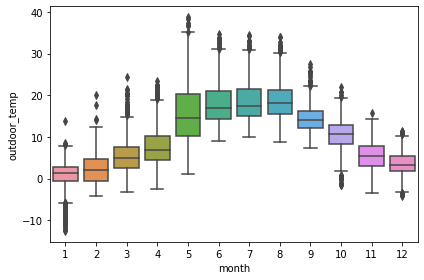

In [14]:
dataset['month'] = dataset.index.month
f, axes = plt.subplots()
sns.boxplot(data=dataset.loc['2017'], x='month' , y='outdoor_temp');
f.tight_layout()

In [15]:
def reg_fit(X,Y,Z,T):
    reg = linear_model.LinearRegression()
    reg.fit(X.values.astype('float32').reshape(-1,1), Y.values.astype('float32').reshape(-1,1))
    print('=' + str(reg.intercept_[0])+'.outdoor_temp + ('+ str(reg.coef_[0][0])+')')
    Y_all_pred = reg.predict(Z.values.astype('float32').reshape(-1,1)) 
    Y_pred = reg.predict(X.values.astype('float32').reshape(-1,1)) 
    return(T.values.astype('float32').reshape(-1,1) - 
               reg.predict(Z.values.astype('float32').reshape(-1,1)),Y_pred, Y_all_pred)

=6.451327.outdoor_temp + (-0.36252043)


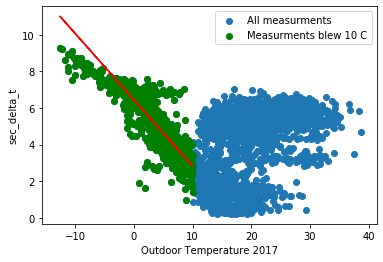

=57.037075.outdoor_temp + (-0.71705383)


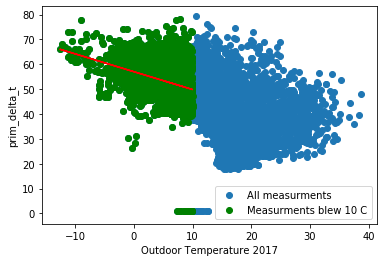

=78.08341.outdoor_temp + (-4.116984)


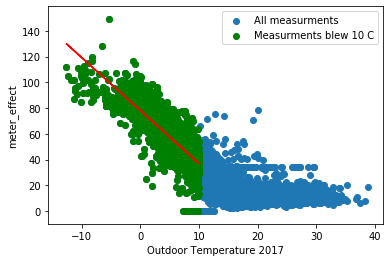

=1202.9756.outdoor_temp + (-55.703472)


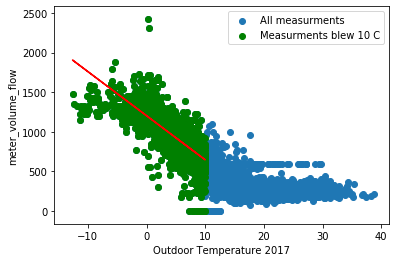

=0.98084545.outdoor_temp + (-0.0049356157)


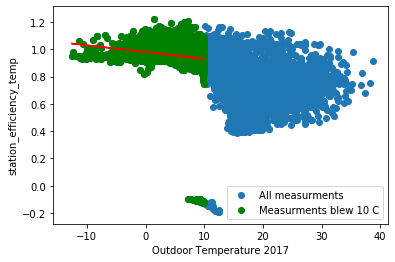

=6.242494.outdoor_temp + (-0.332558)


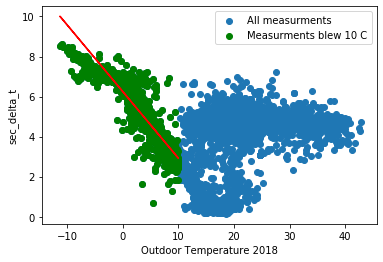

=57.175583.outdoor_temp + (-0.7595278)


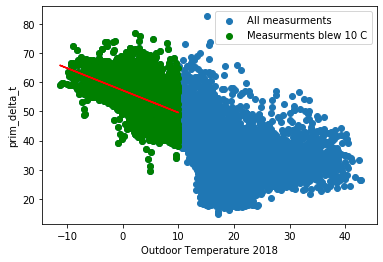

=76.66218.outdoor_temp + (-3.6871474)


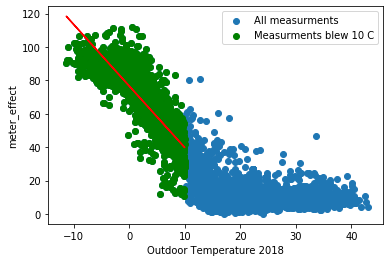

=1159.5717.outdoor_temp + (-44.387245)


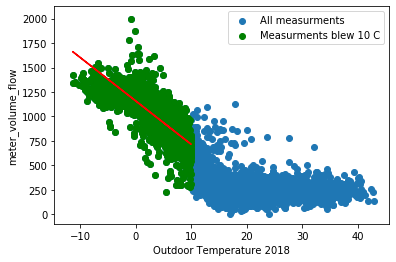

=0.97937524.outdoor_temp + (-0.0010900368)


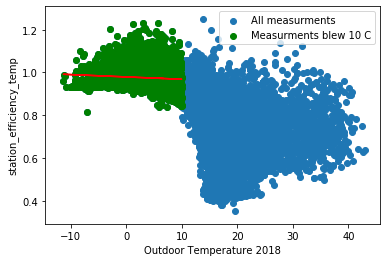

In [16]:
dataset_name = hampel_dataset
dataset_reg = pd.DataFrame()
start = ['2017', '2018']
for year in start:
    result = dataset_name.loc[year].copy()
    for column in ['sec_delta_t','prim_delta_t', 'meter_effect', 'meter_volume_flow', 'station_efficiency_temp']:
        df = dataset_name[(dataset_name['outdoor_temp']<=10)].loc[year]
        result[column + '_'], Y_pred, Y_all_pred = reg_fit(df['outdoor_temp'], df[column],
                                                 result['outdoor_temp'], result[column])
        plt.scatter(result['outdoor_temp'], result[column], label='All measurments')
        plt.scatter(df['outdoor_temp'], df[column],c='green',label='Measurments blew 10 C')
        plt.plot(df['outdoor_temp'], Y_pred, c='red')
        plt.xlabel('Outdoor Temperature ' + year)
        plt.ylabel(column)
        plt.legend()
        plt.savefig(data_path + substation +'_'+ column +'_'+ year +'_.pdf',format='pdf')
        plt.show()
    dataset_reg = dataset_reg.append(result)
dataset_reg.name = 'dataset_reg'

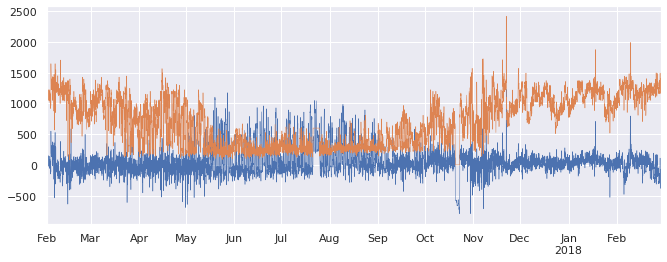

In [17]:
sns.set(rc={'figure.figsize':(11, 4)})
dataset_reg.loc['2017-02':'2018-02','meter_volume_flow_'].plot(linewidth=0.5);
hampel_dataset.loc['2017-02':'2018-02','meter_volume_flow'].plot(linewidth=0.5);

In [18]:
dataset_reg.to_csv(data_path + substation + '_' + dataset_name.name + '_hourly.csv')

In [19]:
reg_zscore_dataset = pd.DataFrame()
reg_zscore_dataset = zscore_(
    dataset_reg[['sec_delta_t_','prim_delta_t_','meter_effect_',
                    'meter_volume_flow_', 'station_efficiency_temp_']], 'D')

reg_zscore_dataset = pd.DataFrame(data = reg_zscore_dataset, 
                      columns = ['sec_delta_t_','prim_delta_t_','meter_effect_',
                                 'meter_volume_flow_', 'station_efficiency_temp_'],
                     index = dataset.index)

reg_zscore_dataset['year'] = reg_zscore_dataset.index.year
reg_zscore_dataset['month'] = reg_zscore_dataset.index.month
reg_zscore_dataset['weekday_name'] = reg_zscore_dataset.index.weekday_name
reg_zscore_dataset.name = 'reg_zscore_dataset'

In [20]:
Frequency = 'W'
week_dates = []
hampel_dataset_stats = pd.DataFrame()

for date, group in dataset_reg[['sec_delta_t','prim_delta_t','meter_effect',
         'meter_prim_return_temp','meter_prim_supply_temp',
         'meter_volume_flow','outdoor_temp','sec_return_temp',
         'sec_supply_temp', 'station_efficiency_temp']].groupby(pd.Grouper(freq=Frequency)):
    week_dates.append(date.date())

    hampel_dataset_stats = [hampel_dataset_stats, group.describe()]
    hampel_dataset_stats = pd.concat(hampel_dataset_stats)
if 'year' in hampel_dataset_stats.columns:
    hampel_dataset_stats = hampel_dataset_stats.drop(['year', 'month'], axis=1)    
hampel_dataset_statsemp = hampel_dataset_stats.reset_index(drop=True)

index = pd.MultiIndex.from_product([week_dates, ['count','mean','std','min','25%', '50%', '75%', 'max']],
                                   names=['week_date', 'statistics'])

hampel_dataset_stats = pd.DataFrame(data = hampel_dataset_stats.values, 
                                    index = index, 
                                    columns = ['sec_delta_t','prim_delta_t','meter_effect',
                                         'meter_prim_return_temp','meter_prim_supply_temp',
                                         'meter_volume_flow','outdoor_temp','sec_return_temp',
                                         'sec_supply_temp', 'station_efficiency_temp']) 

In [21]:
est_1 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
est_2 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')


disc_labels_1 = ['low', 'low_medium', 'medium_high', 'high']

data_col = ['sec_delta_t_','prim_delta_t_', 'meter_effect_', 
            'meter_volume_flow_', 'station_efficiency_temp_']

result = pd.DataFrame()

dataset_name = reg_zscore_dataset

data_1 = dataset_name[data_col].copy()
data_1 = data_1.dropna()

for date, group in data_1.groupby(pd.Grouper(freq='AS')):
    print(date, len(group))
    data = pd.DataFrame(group)
    
    for column in data.columns: 
        est_1.fit(data[column].values.astype('float32').reshape(-1,1))
        data[column] = est_1.transform(data[column].values.astype('float32').reshape(-1,1))
        data[column] = data[column].astype(int).astype(str)
        for n,t in enumerate(disc_labels_1):
            data[column] = data[column].replace(str(n), t)
    result = result.append(data)
    
for index, row in result.iterrows():
    dataset.set_value(index.value, 'sequence', ','.join(row.values))

dataset = dataset.dropna()
dataset.to_csv(data_path + substation + '_' + dataset_name.name + '_hourly_disc.csv')

2017-01-01 00:00:00+00:00 8760
2018-01-01 00:00:00+00:00 8760


In [22]:
dataset_ = pd.read_csv(data_path + substation + '_' + dataset_name.name 
                       + '_hourly_disc.csv', header=0, index_col=0, parse_dates=True)

Frequency = 'w'
week_dates = []
for date, group in dataset_.groupby(pd.Grouper(freq=Frequency)):
    week_dates.append(str(date.date()))

In [23]:
sample_date = '2017_2018'

In [24]:
import time
import math
from prefixspan import PrefixSpan

dataset_ = pd.read_csv(data_path + substation + '_' + dataset_name.name 
                       + '_hourly_disc.csv', header=0, index_col=0, parse_dates=True)

Frequency = 'w'
week_dates = []

for date, group in dataset_.groupby(pd.Grouper(freq=Frequency)):
    event_seq = pd.DataFrame(group, columns=['sequence'])
    
    if len(event_seq) < 1:
        print('The date '+ str(date.date()) + ' is missing.')
    else:
        selected_patterns = []
        unmatched_patterns = []
        
        temp_dataset = pd.DataFrame()
        all_patterns = pd.DataFrame()
        start_time = time.time()

        len_dataset = (len(group))
        dataset_seq = []
        
        for values in event_seq.values.tolist():
            for value in values:
                dataset_seq.append(value.split(','))
        ps = []
        ps = PrefixSpan(dataset_seq)
        ps.minlen = len(dataset_seq[0])

        minsup = math.floor(len_dataset * 0.01)
       
        prefix_results = ps.frequent(minsup, closed=False)
        prefix_results.sort()
        prefix_results.sort(key=lambda tup: len(tup[1]), reverse=True)
        prefix_results = pd.DataFrame(prefix_results,columns=['support','pattern'])

        mataced_patterns_count = 0
        unmatched_patterns_count = 0
        number_of_matches = 0

        temp_dataset = group.copy()
        temp_dataset['pattern'] = '-'

        for row in prefix_results.pattern:
            pattern = ','.join(row)
            num_matches = len(group[group['sequence'] == pattern])
            
            if (pattern != ''):
                if (num_matches > 0):
                    temp_dataset['pattern'] = np.where((temp_dataset['sequence'] == pattern)
                                                       & ~(temp_dataset['pattern'] == pattern),
                                                       temp_dataset['pattern'].astype(str) + pattern + '-', 
                                                       temp_dataset['pattern'])
                    
                    avg_outdoor_temp = temp_dataset['outdoor_temp'].loc[temp_dataset['sequence'] == pattern].mean()

                    mataced_patterns_count += 1
                    selected_patterns.append([date.date(), pattern, len(pattern.split(',')), num_matches, avg_outdoor_temp])
            elif (num_matches == 0): #
                unmatched_patterns.append([date.date(), pattern, len(pattern.split(',')), 0])
                unmatched_patterns_count += 1
        
        selected_patterns = pd.DataFrame(selected_patterns)
        selected_patterns = pd.DataFrame({'date':pd.to_datetime(selected_patterns[0]), 
                                          'pattern':selected_patterns[1],'pattern_len':selected_patterns[2], 
                                          'frequency':selected_patterns[3], 'avg_outdoor_temp': selected_patterns[4]})
        
        week_dates.append(str(date.date()))
        print(date.date(),
              ', dataset lenght:' , len_dataset,
              ', No. of patterns:', len(selected_patterns), 
              ', min_len:', selected_patterns['pattern_len'].min(), 
              ', max_len:', selected_patterns['pattern_len'].max())
        selected_patterns.to_csv(data_path + 'selected_patterns_' + dataset_name.name + '_' + str(date.date()) + '.csv', index=False)

        if len(unmatched_patterns) > 0 :
            unmatched_patterns = pd.DataFrame(unmatched_patterns)
            unmatched_patterns = pd.DataFrame({'date':pd.to_datetime(unmatched_patterns[0]), 
                                               'pattern':unmatched_patterns[1],'pattern_len':unmatched_patterns[2], 
                                               'frequency':unmatched_patterns[3]})
        
        temp_dataset.to_csv(data_path + 'frequent_patterns_' + dataset_name.name + '_' + str(date.date()) + '.csv', index=True)
        stop_time = time.time()
        print('Execution time: ' + repr(round((stop_time - start_time),0)) + ' sec')
        print()

In [25]:
source_output = os.listdir(data_path)

selected_patterns = pd.DataFrame()
frequent_patterns = pd.DataFrame()
sample_date = '2017_2018'

dates = []
for date_ in week_dates:
    dates.append(str(date_))

# Merging selected patterns
for date_ in dates:
    for file in source_output:
        if file.startswith('selected_patterns_' + dataset_name.name) and file.endswith('.csv') and file[-14:-4] == date_:
            print(file)
            data = pd.read_csv(data_path + file)
            selected_patterns = [selected_patterns, data]
            selected_patterns = pd.concat(selected_patterns, ignore_index=True)
selected_patterns.to_csv(data_path + 'selected_patterns-' 
                             + dataset_name.name + '_' + sample_date + '_.csv', index=False)

# Merging all extracted patterns
for date_ in dates:
    for file in source_output:
        if file.startswith('frequent_patterns_' + dataset_name.name) and file.endswith('.csv') and file[-14:-4] == date_:
            print(file)
            data = pd.read_csv(data_path + file)
            frequent_patterns = [frequent_patterns, data]
            frequent_patterns = pd.concat(frequent_patterns, ignore_index=True)  

frequent_patterns.rename(columns={'Unnamed: 0':'date'}, inplace=True)    
frequent_patterns.to_csv(data_path + 'frequent_patterns-' 
                             + dataset_name.name + '_' + sample_date + '_.csv', index=False)

In [26]:
import time
import datetime
from datetime import timedelta 

import networkx as nx
from networkx import tree
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AffinityPropagation

result = []

substations = ['F-4']

for substation in substations:
    data_path = data_dir + substation + '/'

    all_patterns = pd.read_csv(data_path + 'frequent_patterns-' + dataset_name.name +'_'+ sample_date + '_.csv', \
                               header=0, index_col=0, parse_dates=True)

    all_patterns['week_cluster_1'] = '-'
    all_patterns['week_cluster_2'] = '-'
    all_patterns['cluster_exemplar'] = 0
    all_patterns['concesus_cluster_1'] = '-'
    all_patterns['cc_exemplar_1'] = 0
    all_patterns['concesus_cluster_2'] = '-'
    all_patterns['cc_exemplar_2'] = 0
    
    all_patterns['weight_1'] = 1
    all_patterns['weight_2'] = 1
    all_patterns['outlier_1'] = 1
    all_patterns['outlier_2'] = 1


    dates = week_dates

    
    c_d = []
    w_c_d = []
    avg_outdoor_2_weeks = []
    time_window = 0
    clusters=['C','C\'']
    changes = []

    for date_index in range(len(dates)):

        if date_index+1 < len(dates):


            w_1_mPattern_id, w_1_mPattern, w_1_mfsp, w_1_mfsp_freq = mfsp_finder(read_df(dates[date_index],
                                                                                         dataset_name.name))
            w_2_mPattern_id, w_2_mPattern, w_2_mfsp, w_2_mfsp_freq = mfsp_finder(read_df(dates[date_index + 1], 
                                                                                         dataset_name.name))

            ##############################################################################

            mfsp_id_matrix_editDist = editDist_matrix(w_1_mPattern, w_1_mPattern)
            mfsp_id_matrix_editDist = mfsp_id_matrix_editDist

            nmfsp_id_matrix_editDist = editDist_matrix(w_2_mPattern, w_2_mPattern)
            nmfsp_id_matrix_editDist = nmfsp_id_matrix_editDist

            ##############################################################################

            weekly_patterns = [w_1_mPattern_id, w_2_mPattern_id]
            distance_matrices = [mfsp_id_matrix_editDist, nmfsp_id_matrix_editDist]
            af_labels = []
            af_n_clusters_centroid = []
            af_n_clusters = []
            af_silhouette_avg = []
            davies_bouldin_score_avg = []

            kk = 0

            for distance_matrix in distance_matrices:
                af = AffinityPropagation().fit(distance_matrix)
                cluster_centers_indices = af.cluster_centers_indices_
                af_labels.append(af.labels_)
                af_n_clusters_centroid.append(cluster_centers_indices)
                af_n_clusters.append(len(cluster_centers_indices))


                week_end = datetime.datetime.strptime(dates[date_index + kk], '%Y-%m-%d')
                week_start = week_end.date() - timedelta(days=6)

                temp_ = all_patterns.loc[week_start:dates[date_index+kk]]
                cluster_pattern = []

                zipped = zip(weekly_patterns[kk], af_labels[kk])
                
                i = 0
                j = 0
                for s, c in zipped:
                    for index, row in temp_[temp_['sequence'] == s[0]].iterrows():

                        if af_n_clusters_centroid[kk][i] == j:
                            all_patterns.at[index, 'cluster_exemplar'] = 1

                            if len(af_n_clusters_centroid[kk]) > i+1:
                                i+=1
                        
                        all_patterns.at[index, 'week_cluster_' + str(time_window%2 +1)] = \
                        'W'+str(time_window + 1 + kk)+ ',' + clusters[kk] + str(c) 
                    j+=1
                    
                kk+=1

            #############################################################################
            aa, bb, cc, dd = weighted_clusters_distance([w_1_mPattern, w_2_mPattern], 
                                    af_n_clusters_centroid, 
                                    af_labels, 
                                    [w_1_mfsp_freq, w_2_mfsp_freq])

           
            avg_outdoor_2_weeks.append(round((w_1_mfsp['avg_outdoor_temp'].mean() 
                                              + w_2_mfsp['avg_outdoor_temp'].mean())/2,2))
            w_c_d.append(aa)
            
            aa, bb, cc, dd = clusters_distance([w_1_mPattern, w_2_mPattern], 
                                    af_n_clusters_centroid, 
                                    af_labels, 
                                    [w_1_mfsp_freq, w_2_mfsp_freq])
            
            c_d.append(aa)
            
            if w_c_d[-1] > 0.25 and (w_1_mfsp['avg_outdoor_temp'].mean() <= 10 and w_2_mfsp['avg_outdoor_temp'].mean() <= 10):
                editDist_w_1_2, cluster_area_w_1_2, exemplar_w_1_2, cluster_outdoor_temp_w_1_2 = exemplar_to_pattern_distance(
                                                                                    [w_1_mPattern, w_2_mPattern], 
                                                                                    af_n_clusters_centroid, 
                                                                                    af_labels, 
                                                                                    [w_1_mfsp_freq, w_2_mfsp_freq],
                                                                                    [w_1_mfsp['avg_outdoor_temp'], 
                                                                                     w_2_mfsp['avg_outdoor_temp']])

                ##############################################################################

                af = AffinityPropagation().fit(editDist_w_1_2)

                two_week_patterns = []
                for row in exemplar_w_1_2:
                    two_week_patterns.append([','.join(row)])

                week_end = datetime.datetime.strptime(dates[date_index+1], '%Y-%m-%d')
                week_start = week_end.date() - timedelta(days=13)

                temp_ = all_patterns.loc[week_start:dates[date_index+1]]
                cluster_pattern = []
                zipped = zip(two_week_patterns, af.labels_)
                
                i = 0
                j = 0
                
                for s, c in zipped:
                    for index, row in temp_[temp_['sequence'] == s[0]].iterrows():
                        ws_cluster = 'W'+str(time_window + 1)+ \
                                     ','+str(time_window + 2)+ \
                                     ','+clusters[time_window%2]+str(c)

                        if af.cluster_centers_indices_[i] == j:
                            all_patterns.at[index, 'cc_exemplar_' + str(time_window%2+1)] = 1

                            if len(af.cluster_centers_indices_) > i+1:
                                i+=1
                        
                        all_patterns.at[index, 'concesus_cluster_' + str(time_window%2+1)] = ws_cluster
                    j+=1


                temp_ = all_patterns.loc[week_start:dates[date_index+1]]

                for c in temp_['week_cluster_' + str(time_window%2+1)].unique():

                    mask = all_patterns['week_cluster_' + str(time_window%2+1)] == c
                    l = all_patterns.loc[mask, 'concesus_cluster_' + str(time_window%2+1)].unique()
                    l = np.delete(l,np.where(l=='-'), axis=0)

                    all_patterns.loc[mask, 'concesus_cluster_' + str(time_window%2+1)] = l[0]


                x, y, z, t = exemplar_to_pattern_distance([exemplar_w_1_2], 
                                               [af.cluster_centers_indices_], 
                                               [af.labels_], 
                                               [cluster_area_w_1_2],
                                               [cluster_outdoor_temp_w_1_2])

                ##############################################################################


                G = nx.Graph()
                G.population={}

                weighted_edges = []
                for i in range(len(x)):
                    for j in range(len(x)):
                        weighted_edges.append((i,j,x[i][j]))

                for i in range (len(af.cluster_centers_indices_)):
                #     print(i)
                    freq_ = 0
                    for k, v in zip(af.labels_, cluster_area_w_1_2):
                        if k == i:

                            freq_ += v
                    G.population[i] = freq_

                G.add_nodes_from(range(len(x)))
                G.add_weighted_edges_from(weighted_edges)

                mst = nx.minimum_spanning_tree(G)
                pos = nx.layout.kamada_kawai_layout(mst)

                ##############################################################################

                removed_edge = []
                mst_edge_weight = []

                if len(mst.edges(data=True)) > 0:
                    for item in mst.edges(data=True):
                        mst_edge_weight.append([(item[0], item[1]), item[2]['weight']])

                    mst_edge_weight = pd.DataFrame(mst_edge_weight)
                    mst_edge_weight = pd.DataFrame({'edge':mst_edge_weight[0], 'weight':mst_edge_weight[1]})

                    for name, group  in mst_edge_weight.groupby('weight'):
                        if name == mst_edge_weight['weight'].max():
                            for item in group['edge']:
                                removed_edge.append(item[0])
                                removed_edge.append(item[1])
                                mst.remove_edge(item[0],item[1])

                ##############################################################################

                a = set()
                b=[]

                for i in range(len(x)):
                    if len(list(mst.neighbors(i))) == 0:
                         b.append({i})
                    else:
                        a.add(i)
                        for j in mst.neighbors(i):
                            a.add(j)
                            for k in mst.neighbors(j):
                                a.add(k)
                        if a not in b:
                            b.append(a)
                        a=set()

                c = set()
                d = []
                for i in range(len(b)):
                    for j in range(len(b)):
                        if len(b[i]&b[j]) > 0:
                            c = c.union(b[i])
                            c = c.union(b[j])
                    if len(d) > 0:
                        for item in d:
                            flag = False
                            if len(c&item) > 0:
                                flag = True
                                d.append(c.union(item))
                                d.remove(item)
                        if flag == False:
                            d.append(c)
                    else:
                        d.append(c)
                    c = set()

                temp = []
                min_pattern_percent = 1.0

                for item ,p in zip(d,z):

                    a=0
                    pattern_percent = 0

                    for i in item:
                        a+=int(y[i])
                    pattern_percent = round(a/sum(y),2)
                    if pattern_percent < min_pattern_percent:
                        min_pattern_percent = pattern_percent
                    temp.append([item, a, pattern_percent])


                c = all_patterns.loc[week_start:dates[date_index+1], 'concesus_cluster_'+ str(time_window%2+1)].unique()
                changes.append(time_window)

                for item in temp:

                    for j in range(len(item[0])):
                        result.append([dates[date_index],
                                      dates[date_index+1],
                                      item[0],
                                      z[list(item[0])[j]],
                                      item[1], 
                                      item[2],
                                      round(t[list(item[0])[j]],2)])

                        mask = all_patterns['concesus_cluster_' + str(time_window%2+1)] == c[0][0:-1]+str(list(item[0])[j])
                        all_patterns.loc[mask, 'weight_'+ str(time_window%2+1)] = item[2]
                        if min_pattern_percent == item[2]:
                            all_patterns.loc[mask, 'outlier_' + str(time_window%2+1)] = item[2]

        time_window += 1

    exists = os.path.isfile(data_dir + 'substation_profile_'+ sample_date + '.csv')
    if exists:
        df_1=pd.read_csv(data_dir + 'substation_profile_'+ sample_date + '.csv', header=0, index_col = False)
        df_2=pd.DataFrame({substation+' w_c_d': w_c_d, substation+' c_d': c_d, substation + ' avg_outdoor': avg_outdoor_2_weeks})
        pd.concat([df_1, df_2], axis=1).to_csv(data_dir + 'substation_profile_'+ sample_date + '.csv', index =False)
    else:
        pd.DataFrame({substation+' w_c_d': w_c_d, substation+' c_d': c_d, substation + ' avg_outdoor': avg_outdoor_2_weeks}).to_csv(data_dir + 'substation_profile_'+ sample_date + '.csv')
        
    exists = os.path.isfile(data_dir + 'detected_changes_2_weeks_'+ sample_date + '.csv')
    if exists:
        df_1=pd.read_csv(data_dir + 'detected_changes_2_weeks_'+ sample_date + '.csv', header=0, index_col = False)
        df_2=pd.DataFrame(changes, columns=[substation])
        pd.concat([df_1, df_2], axis=1).to_csv(data_dir + 'detected_changes_2_weeks_'+ sample_date + '.csv', index =False)
    else:
        pd.DataFrame(changes, columns=[substation]).to_csv(data_dir + 'detected_changes_2_weeks_'+ sample_date + '.csv')
    
    result = pd.DataFrame(result, columns=['week_1','week_2','cluster','pattern','frequency','weight','outdoor_temp'])
    result.to_csv(data_path + substation + '_' + dataset_name.name + '_detected_outliers.csv')
    all_patterns.to_csv(data_path + substation + '_' + dataset_name.name + '_' + sample_date + '_outliers.csv')

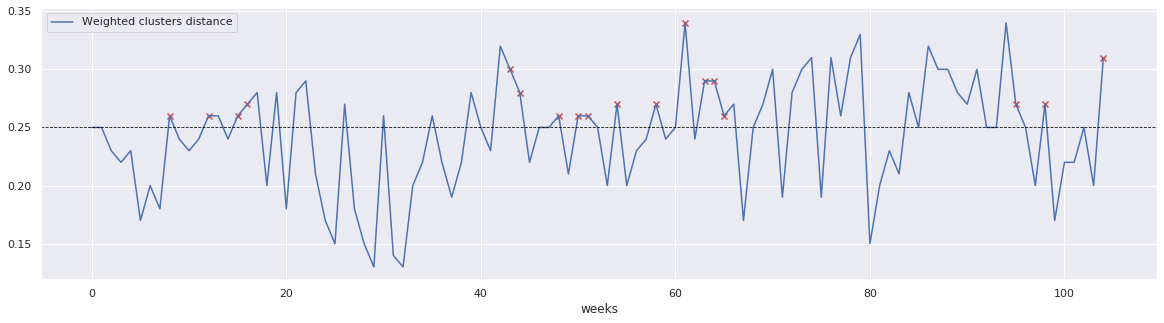

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(pd.DataFrame(w_c_d), label = 'Weighted clusters distance')
ax.scatter(list(set(changes)),pd.DataFrame(w_c_d).loc[list(set(changes))], marker="x", color='r')
ax.axhline(y=0.25, linestyle='--', color ='black', linewidth=0.8)

plt.xlabel('weeks')
plt.legend()

In [32]:
s_efficiency_outlier = []

df_1=all_patterns[(all_patterns['cluster_exemplar'] == 1)]


for name, group in df_1.groupby('week_cluster_1', sort=False):
    if name != '-':
        s_efficiency_outlier.append([list(group.index.date)[0], str(list(group.index.week)[0]), name,
                                     group['sequence'][0],
                                     group['station_efficiency_temp'].mean(),
                                     group['meter_effect'].mean(),
                                     group['meter_volume_flow'].mean(),
                                     group['outdoor_temp'].mean(),
                                     group['cluster_exemplar'][0],
                                     group['cluster_exemplar'].count()
                                    ])

s_efficiency_outlier = pd.DataFrame(
    s_efficiency_outlier, 
    columns = ['date', 'week_no','week_cluster','pattern' , 'station_efficiency_temp', 'meter_effect',
               'meter_volume_flow', 'outdoor_temp','exemplar', 'count']
)

s_efficiency_outlier

s_efficiency_outlier = s_efficiency_outlier.drop_duplicates()
s_efficiency_outlier['date'] = pd.to_datetime(s_efficiency_outlier['date'])
s_efficiency_outlier = s_efficiency_outlier.set_index('date')

s_efficiency_outlier = s_efficiency_outlier.sort_values(by=['date','week_cluster'])

In [33]:
def convert_cat_to_num (dataset_name):
    
    dataset_name['pattern_id'] = dataset_name['pattern']
    dataset_name['pattern_id'] = dataset_name['pattern_id'].replace('low_medium', '2', regex=True)
    dataset_name['pattern_id'] = dataset_name['pattern_id'].replace('medium_high', '3', regex=True)
    dataset_name['pattern_id'] = dataset_name['pattern_id'].replace('low', '1', regex=True)
    dataset_name['pattern_id'] = dataset_name['pattern_id'].replace('high', '4', regex=True)
    return dataset_name

In [34]:
conv_s_efficiency_outlier = convert_cat_to_num(s_efficiency_outlier)
conv_s_efficiency_outlier
i=0
p = []
exemplars = []
for name, group in s_efficiency_outlier.groupby('date'):
    for cluster, group_ in group.groupby('week_cluster'):
        i +=1
        j = 1
        temp = cluster.replace('\'','')

        for row in group_['pattern_id']:
            p = []
            p.append((row).split(','))
        for f in p[0]:
            exemplars.append([name,
                              temp.split('C', 1)[1],
                              cluster,
                              j ,
                              f])
            j+=1
exemplars = pd.DataFrame(exemplars, columns=['date','cluster','week_cluster','feature','value'])
exemplars.to_csv(data_path + substation + '_' + dataset_name.name + '_' + sample_date  + '_exemplars_.csv')

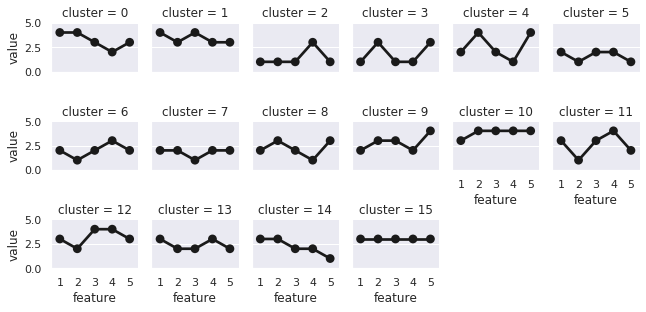

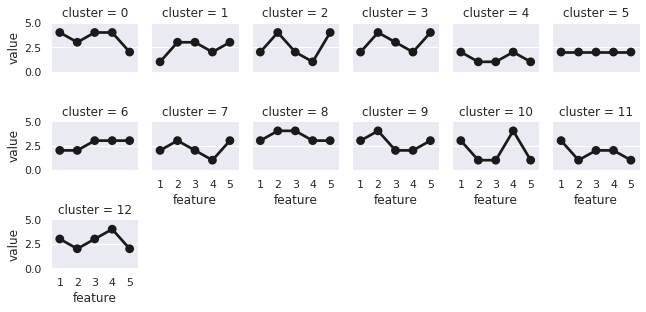

In [35]:
df=pd.read_csv(data_path + substation + '_' + dataset_name.name + '_' + sample_date  + '_exemplars_.csv', 
              header=0, index_col=0, parse_dates=True)

df = df.set_index('date')

g = sns.FacetGrid(df.loc['2017-04-10':'2017-04-16'], col="cluster", col_wrap=6, height=1.5, ylim=(0, 5))
g.map(sns.pointplot, "feature", "value", color=".1", ci=None);
g = sns.FacetGrid(df.loc['2017-04-17':'2017-04-23'], col="cluster", col_wrap=6, height=1.5, ylim=(0, 5))
g.map(sns.pointplot, "feature", "value", color=".1", ci=None);

In [36]:
s_efficiency_outlier = []

df_1=all_patterns[(all_patterns['cc_exemplar_1'] == 1) | (all_patterns['cc_exemplar_2'] == 1)]

for i in range(1,3): 
    for name, group in df_1.groupby('concesus_cluster_' + str(i), sort=False):
        if name != '-':
            s_efficiency_outlier.append([list(group.index.date)[0], str(list(group.index.week)[0]), name,
                                         group['sequence'][0],
                                         group['station_efficiency_temp'].mean(),
                                         group['meter_effect'].mean(),
                                         group['meter_volume_flow'].mean(),
                                         group['outdoor_temp'].mean(),
                                         group['cc_exemplar_' + str(i)][0],
                                         group['outlier_' + str(i)].mean(),
                                         group['outlier_' + str(i)].count(),
                                         np.nan])
    
s_efficiency_outlier = pd.DataFrame(
    s_efficiency_outlier, 
    columns = ['date', 'week_no','concesus_cluster', 'pattern','station_efficiency_temp', 'meter_effect',
               'meter_volume_flow', 'outdoor_temp','exemplar', 'outlier', 'count' , 'outlier_']
)

s_efficiency_outlier

s_efficiency_outlier = s_efficiency_outlier.drop_duplicates()
s_efficiency_outlier['date'] = pd.to_datetime(s_efficiency_outlier['date'])
s_efficiency_outlier = s_efficiency_outlier.set_index('date')

s_efficiency_outlier = s_efficiency_outlier.sort_values(by=['date','concesus_cluster'])

mask = s_efficiency_outlier.outlier < 1
s_efficiency_outlier.loc[mask, 'outlier_'] = s_efficiency_outlier.loc[mask,'station_efficiency_temp']

In [37]:
conv_s_efficiency_outlier = convert_cat_to_num(s_efficiency_outlier)
conv_s_efficiency_outlier
i=0
p = []
exemplars = []
for name, group in s_efficiency_outlier.groupby('date'):
    for cluster, group_ in group.groupby('concesus_cluster'):
        i +=1
        j = 1
        temp = cluster.replace('\'','')

#         print(temp.split('C', 1)[1])
        for row in group_['pattern_id']:
            p = []
            p.append((row).split(','))
        for f in p[0]:
            exemplars.append([name, 
                              #str(temp.split('C', 1)[1]) + ' | E_s: '+ str(round(group_['station_efficiency_temp'].mean(),2)) ,
                              temp.split('C', 1)[1],
                              cluster,
                              j ,
                              f])
            j+=1
exemplars = pd.DataFrame(exemplars, columns=['date','cluster','concesus_cluster','feature','value'])
exemplars.to_csv(data_path + substation + '_' + dataset_name.name + '_' + sample_date  + 'conc_exemplars_.csv')

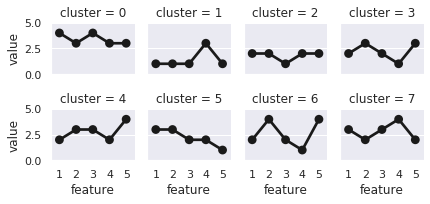

In [38]:
df_1=pd.read_csv(data_path + substation + '_' + dataset_name.name + '_' + sample_date  + 'conc_exemplars_.csv', 
              header=0, index_col=0, parse_dates=True)
 
df_1 = df_1.set_index('date')
g = sns.FacetGrid(df_1.loc['2017-04-10':'2017-04-14'], col="cluster", col_wrap=4, height=1.5, ylim=(0, 5))
g.map(sns.pointplot, "feature", "value", color=".1", ci=None);
g.savefig(data_path + substation + '_' + dataset_name.name + '_2017-04-10_conc_exemplars_.pdf', format='pdf')

In [39]:
s_efficiency_outlier = []

for i in range(1,3):

    for name, group in all_patterns.groupby('concesus_cluster_' + str(i), sort=False):
        if name != '-':
            s_efficiency_outlier.append([list(group.index.date)[0], str(list(group.index.week)[0]), name,
                                         group['station_efficiency_temp'].mean(),
                                         group['meter_effect'].mean(),
                                         group['meter_volume_flow'].mean(),
                                         group['outdoor_temp'].mean(),
                                         group['outlier_' + str(i)].mean(),
                                         group['outlier_' + str(i)].count(),
                                         np.nan])
    
s_efficiency_outlier = pd.DataFrame(
    s_efficiency_outlier, 
    columns = ['date', 'week_no','concesus_cluster','substation_efficiency', 'meter_effect',
               'meter_volume_flow', 'outdoor_temp','outlier', 'count' , 'detected_deviations']
)

s_efficiency_outlier = s_efficiency_outlier.drop_duplicates()
s_efficiency_outlier['date'] = pd.to_datetime(s_efficiency_outlier['date'])
s_efficiency_outlier = s_efficiency_outlier.set_index('date')

s_efficiency_outlier = s_efficiency_outlier.sort_values(by=['date','concesus_cluster'])

mask = s_efficiency_outlier.outlier < 1
s_efficiency_outlier.loc[mask, 'detected_deviations'] = s_efficiency_outlier.loc[mask,'substation_efficiency']

In [40]:
deviations_week_clus = []

df=s_efficiency_outlier.dropna()
df.loc['2017','concesus_cluster'].str.extract('(W\d{0,},\d{0,},[C\\\']+)', expand=True)[0]
week_clus = df.loc['2017','concesus_cluster'].str.extract('(W\d{0,},\d{0,},[C\\\']+)', expand=True)[0]
for name, group in df.loc['2017'].groupby(week_clus, sort=False):
    deviations_week_clus.append(
        [group.index.month[0],group['concesus_cluster'].str.extract('(W\d{0,},\d{0,})', expand=True)[0].unique()[0],
         name,
         group['count'].sum()])

deviations_week_clus = pd.DataFrame(deviations_week_clus,columns=['month','date','cluster','count'])
deviations_week_clus = deviations_week_clus.set_index('date')

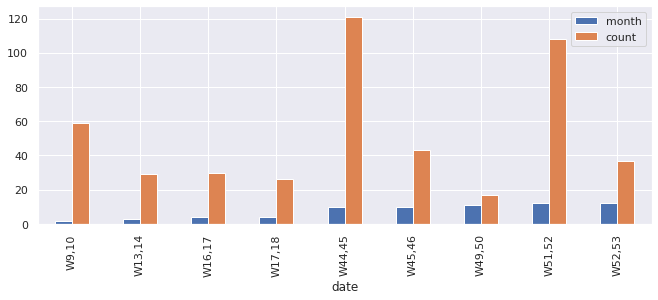

In [41]:
deviations_week_clus.plot.bar();

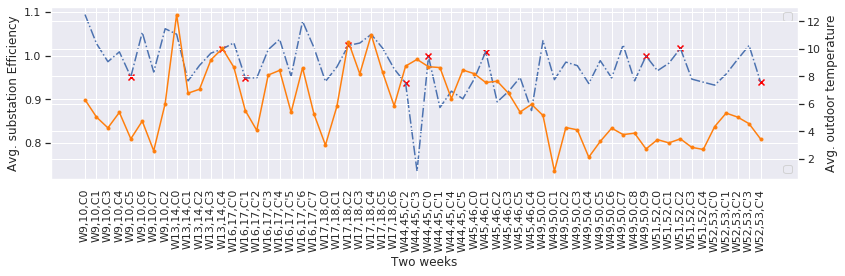

In [46]:
start = ['2017']
for year in start:    
    fig, ax1 = plt.subplots(figsize=(12, 4))
    color = 'tab:blue'
    ax1.plot(s_efficiency_outlier.loc[year,'concesus_cluster'],
             s_efficiency_outlier.loc[year,'substation_efficiency'], linestyle ='-.')
    ax1.scatter(s_efficiency_outlier.loc[year, 'concesus_cluster'],
                s_efficiency_outlier.loc[year,'detected_deviations'], marker='x', color='red')
    ax1.set_ylabel('Avg. substation Efficiency')
    ax1.tick_params(axis='y')
    plt.xticks(rotation=90)
    ax1.set_xlabel('Two weeks')
    ax1.legend()

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Avg. outdoor temperature')
    ax2.tick_params(axis='y')
    ax2.plot(s_efficiency_outlier.loc[year,'concesus_cluster'],
             s_efficiency_outlier.loc[year,'outdoor_temp'], color=color, marker='.')

    ax2.legend(loc='lower right')

    fig.tight_layout()
    plt.savefig(data_path + substation + '_' + dataset_name.name + '_' 
                           + year + '_concesus_cluster_outlier_.pdf',format='pdf')

    plt.show()

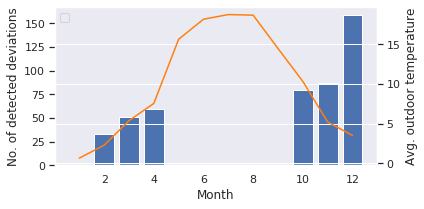

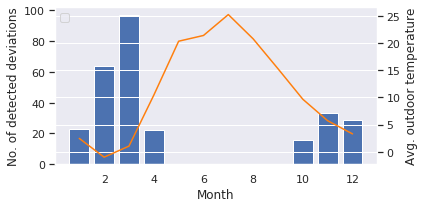

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

all_patterns['day_of_week'] = all_patterns.index.dayofweek
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
all_patterns['day_of_week'] = all_patterns['day_of_week'].map(dmap)

all_patterns['hour'] = all_patterns.index.hour
all_patterns['month'] = all_patterns.index.month

start = ['2017' ,'2018']
for year in start:
    outlier=[]
    index_=[]
    
    temp_ = all_patterns.loc[year]
    for i in range(1,2):
        for name, group in temp_.groupby('month'):
            index_.append(name)
            outlier.append([name, group[group['outlier_' + str(i)] < 1]['outlier_' + str(i)].count() +\
                                  group[group['outlier_' + str(i+1)] < 1]['outlier_' + str(i+1)].count(), \
                                                                        group['outdoor_temp'].mean()])
    
    outlier = pd.DataFrame(outlier, columns=['month','count','outdoor temperature']) 
    outlier = outlier.sort_values(by=['month'])
    outlier = outlier.reset_index(drop=True)
    
    fig, ax1 = plt.subplots(figsize=(6, 3))
    plt.grid(False)
    
    color = 'tab:blue'
    ax1.bar(outlier['month'],outlier['count'])

    ax1.set_ylabel('No. of detected deviations')#, color=color)

    ax1.set_xlabel('Month')


    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.plot(outlier['month'],outlier['outdoor temperature'], color=color)
    ax2.set_ylabel('Avg. outdoor temperature')
    ax2.legend(loc='upper left')

    fig.tight_layout()

In [48]:
outlier=[]
outdoor =[]
index_=[]
temp_ = all_patterns.loc['2017']
for name, group in temp_.groupby('month'):
    for n, g in group.groupby('day_of_week'):
        index_.append((name, n))
        outlier.append((g[g['outlier_1'] < 1]).outlier_1.count()+(g[g['outlier_2'] < 1]).outlier_2.count())
        outdoor.append(round(((g[g['outlier_1'] <= 1]).outdoor_temp.mean()+ \
                              (g[g['outlier_2'] <= 1]).outdoor_temp.mean())/2,2))

s_outlier=pd.Series(outlier, index=index_)
s_outdoor=pd.Series(outdoor, index=index_)

index_ = pd.MultiIndex.from_tuples(index_)
s_outlier = s_outlier.reindex(index_)
s_outdoor = s_outdoor.reindex(index_)

column_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
s_outlier = s_outlier.reindex(column_order, axis=1, level=1)
s_outdoor = s_outdoor.reindex(column_order, axis=1, level=1)

s_outlier.index.names = ['month','day_of_week']
s_outdoor.index.names = ['month','day_of_week']

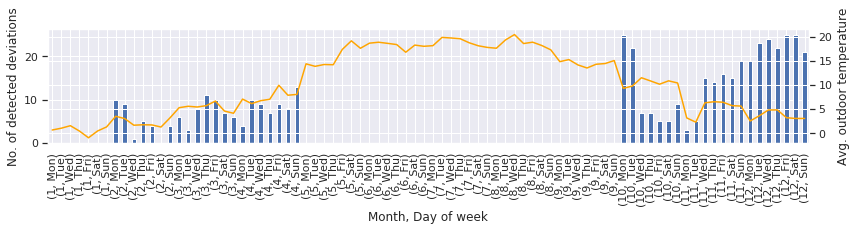

In [50]:
fig, ax = plt.subplots(figsize=(12, 3))
s_outdoor.plot(color='orange',secondary_y=True);
s_outlier.plot.bar();
ax.set_xlabel('Month, Day of week')
ax.right_ax.set_ylabel('Avg. outdoor temperature')
ax.set_ylabel('No. of detected deviations')
plt.xticks(rotation=90)
fig.tight_layout()

plt.savefig(data_path + substation + '_' + dataset_name.name + '_' 
                       + year + 'detected_outliers_outdoor.pdf',format='pdf')

plt.show()